In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

In [2]:
def make_polygon(points,n):
    new_points = np.zeros([n,3],float)
    t = np.arange(points.shape[0], dtype=float)
    t /= t[-1]
    nt = np.linspace(0, 1, n)
    tck, u = scipy.interpolate.splprep(points.T, s=0)
    new_points = scipy.interpolate.splev(nt, tck) 
    return np.array(new_points).T

In [3]:
def make_nurbs(points,n):
    
    nP = points.shape[0]
    new_points = np.zeros([n,3],float)
    
    x = points[:,0]
    y = points[:,1]
    z = points[:,2]

    t = range(nP)
    ipl_t = np.linspace(0.0, nP - 1, n)

    x_tup = scipy.interpolate.splrep(t, points[:,0], k=3)
    y_tup = scipy.interpolate.splrep(t, points[:,1], k=3)
    z_tup = scipy.interpolate.splrep(t, points[:,2], k=3)

    x_list = list(x_tup)
    xl = x.tolist()
    x_list[1] = xl + [0.0, 0.0, 0.0, 0.0]

    y_list = list(y_tup)
    yl = y.tolist()
    y_list[1] = yl + [0.0, 0.0, 0.0, 0.0]

    z_list = list(z_tup)
    zl = z.tolist()
    z_list[1] = zl + [0.0, 0.0, 0.0, 0.0]

    new_points[:,0] = scipy.interpolate.splev(ipl_t, x_list)
    new_points[:,1] = scipy.interpolate.splev(ipl_t, y_list)
    new_points[:,2] = scipy.interpolate.splev(ipl_t, z_list)
    
    return new_points

In [4]:
def make_fillet(points,arc_rad,deg_div):
    
    nP = points.shape[0]
    new_points = np.zeros([0,3],float)
    new_points = np.append(new_points,[points[0,:]],axis=0)
    
    for i in range(nP)[1:-1]:
        p1 = np.copy(points[i-1,:])
        p2 = np.copy(points[i,:])
        p3 = np.copy(points[i+1,:])
    
        d12 = p2-p1
        d23 = p3-p2
        
        d12 *= 1./np.sqrt(np.sum(d12**2,axis=0))
        d23 *= 1./np.sqrt(np.sum(d23**2,axis=0))
        
        n2 = np.cross(d12,d23)
        n2 *= 1./np.sqrt(np.sum(n2**2,axis=0))
        
        t2 = np.cross(d12,n2)
        t2 *= 1./np.sqrt(np.sum(t2**2,axis=0))
        
        d2c = d23-d12
        d2c *= 1./np.sqrt(np.sum(d2c**2,axis=0))
        
        
        nd12 = np.cross(d12,n2)
        nd12 *= 1./np.sqrt(np.sum(nd12**2,axis=0))
        
        nd23 = np.cross(d23,n2)
        nd23 *= 1./np.sqrt(np.sum(nd23**2,axis=0))
        
        td12 = np.cross(nd12,n2)
        td12 *= 1./np.sqrt(np.sum(td12**2,axis=0))
        
        arc_ang = np.arccos(np.dot(d12,d23))
        dist = arc_rad/np.cos(0.5*arc_ang)

        p2c = p2+dist*d2c

        arc_len = arc_rad * arc_ang
        inc_per_rad = deg_div/(2*np.pi)
        nDiv = int(arc_ang*(deg_div/2/np.pi))
        ang_inc = arc_ang/(nDiv)
        arc_inc = arc_len/float(nDiv)

        Tcs = np.eye(4)
        Tcs[0:3,0] = nd12
        Tcs[0:3,1] = -td12
        Tcs[0:3,2] = n2

        Tpos = np.eye(4)
        Tpos[0:3,3] = p2c
        Trad = np.eye(4)
        Trad[0,3] = arc_rad

        for i in range(nDiv+1):
            ang = float(i)*ang_inc
            Trotz_ang = np.array([[np.cos(ang),-np.sin(ang),0,0],\
                         [np.sin(ang), np.cos(ang),0,0],\
                         [0,0,1,0],\
                         [0,0,0,1]])
            Tarc = np.array(np.matrix(Tpos)*np.matrix(Tcs)*np.matrix(Trotz_ang)*np.matrix(Trad))
            arc_point = Tarc[0:3,3]
            new_points = np.append(new_points,[arc_point],axis=0)
    
    new_points = np.append(new_points,[points[-1,:]],axis=0)

    return new_points

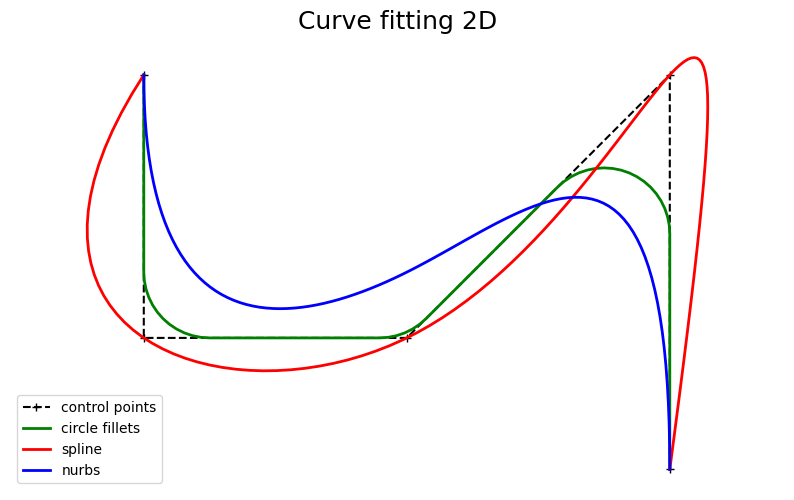

In [5]:
n = 100

points = np.array([[0,2,0],[0,0,0],[2,0,0],[4,2,0],[4,-1,0]],float)

points_poly0 = make_polygon(points,n)
points_bspline0 = make_nurbs(points,n)
arc_rad = 0.5
deg_div = 48
points_fillet0 = make_fillet(points,arc_rad,deg_div)


fig=plt.figure(figsize=(10,6), dpi=100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.plot(points[:,0], points[:,1], '--+k',label='control points')
ax.plot(points_fillet0[:,0], points_fillet0[:,1], '-g',lw=2,label='circle fillets')
ax.plot(points_poly0[:,0], points_poly0[:,1], '-r',lw=2,label='spline')
ax.plot(points_bspline0[:,0], points_bspline0[:,1], '-b',lw=2,label='nurbs')

plt.grid()
plt.axis('off')
plt.axis('equal')
plt.title('Curve fitting 2D',fontsize=18)
plt.legend(loc='lower left')

plt.savefig('curve_fitting_2D.png',dpi=200,format='png',bbox_inches='tight')
plt.show()